Start with standard csv import

In [2]:
import pandas as pd
import requests
import zipfile
import io


dfs = []
FILE_DOWNLOAD_URL = "https://storage.googleapis.com/netguard_bucket/raw_data/GeneratedLabelledFlows.zip"
response = requests.get(FILE_DOWNLOAD_URL)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
  # List all files in the ZIP
  print("Files in ZIP:", z.namelist())

Files in ZIP: ['TrafficLabelling /', 'TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv', 'TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv', 'TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv', 'TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv', 'TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'TrafficLabelling /Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv']


Load only web attacks first, then all attacks to extend approach

In [3]:
target = 'Traffic'
with zipfile.ZipFile(io.BytesIO(response.content)) as z:

  for file in z.namelist()[1:]:
    print(file)
    if target in file:
      print('Found target, adding to dfs')
      with z.open(file) as f:
        dfs.append(pd.read_csv(f, encoding='cp1252'))

TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv
Found target, adding to dfs
TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv
Found target, adding to dfs
TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Found target, adding to dfs


/tmp/ipython-input-3381419425.py:9: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f, encoding='cp1252'))


TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Found target, adding to dfs
TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv
Found target, adding to dfs
TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv
Found target, adding to dfs
TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Found target, adding to dfs
TrafficLabelling /Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Found target, adding to dfs


Convert to dataframe

In [4]:
df = pd.concat(dfs, ignore_index=True)
print(df.shape)
print(df.head())

(3119345, 85)
                                  Flow ID      Source IP   Source Port  \
0  192.168.10.14-209.48.71.168-49459-80-6  192.168.10.14       49459.0   
1  192.168.10.3-192.168.10.17-389-49453-6  192.168.10.17       49453.0   
2   192.168.10.3-192.168.10.17-88-46124-6  192.168.10.17       46124.0   
3  192.168.10.3-192.168.10.17-389-49454-6  192.168.10.17       49454.0   
4   192.168.10.3-192.168.10.17-88-46126-6  192.168.10.17       46126.0   

   Destination IP   Destination Port   Protocol      Timestamp  \
0   209.48.71.168               80.0        6.0  5/7/2017 8:42   
1    192.168.10.3              389.0        6.0  5/7/2017 8:42   
2    192.168.10.3               88.0        6.0  5/7/2017 8:42   
3    192.168.10.3              389.0        6.0  5/7/2017 8:42   
4    192.168.10.3               88.0        6.0  5/7/2017 8:42   

    Flow Duration   Total Fwd Packets   Total Backward Packets  ...  \
0         38308.0                 1.0                      1.0  ...   
1 

Standard preprocessing

In [5]:
print(df[' Label'].value_counts())

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Infiltration                       36
Web Attack – Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


Standard preprocessing cont

In [6]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import numpy as np

#keep labels for later as we are about to drop all non-numeric fields
y = df[' Label']
X = df.drop(columns=[' Label'])

#eliminate infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

#eliminate non-numerical fields
X = X.select_dtypes(include=['number'])

#associate labels to remaining features
y = y[X.index]

X_scaled = preprocessing.scale(X)

pca = PCA(n_components=26)
X_pca = pca.fit_transform(X_scaled)

print("Original", X.shape)
print("Reduced", X_pca.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Original (2827876, 80)
Reduced (2827876, 26)


RNN/LSTM model starts here

source: https://www.tensorflow.org/guide/keras/working_with_rnns

source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

source: https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54

source: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


#info for getting labels, converting to numbers, and later restoring labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)
labels = le.classes_

X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(X_pca, y_onehot, test_size = 0.2)

#LSTM must be 3d, reshape to match
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential([
    Masking(mask_value=0., input_shape=(1, 26)),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train_onehot, validation_split=0.1, epochs=10, batch_size=128)




/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 1, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,295 (317.56 KB)

 Trainable params: 81,295 (317.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.9466 - loss: 0.1916 - val_accuracy: 0.9766 - val_loss: 0.0572
Epoch 2/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.9751 - loss: 0.0589 - val_accuracy: 0.9781 - val_loss: 0.0514
Epoch 3/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9771 - loss: 0.0534 - val_accuracy: 0.9803 - val_loss: 0.0480
Epoch 4/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9781 - loss: 0.0505 - val_accuracy: 0.9789 - val_loss: 0.0464
Epoch 5/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9786 - loss: 0.0487 - val_accuracy: 0.9797 - val_loss: 0.0453
Epoch 6/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9794 - loss: 0.0475 - val_accuracy: 0.9814 - val_loss: 0.0434
Epoch 7/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9797 - loss: 0.0466 - val_accuracy: 0.9820 - val_loss: 0.0436
Epoch 8/10
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 

Confustion Matrix

source: Safeah (NetGuard)

17675/17675 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step


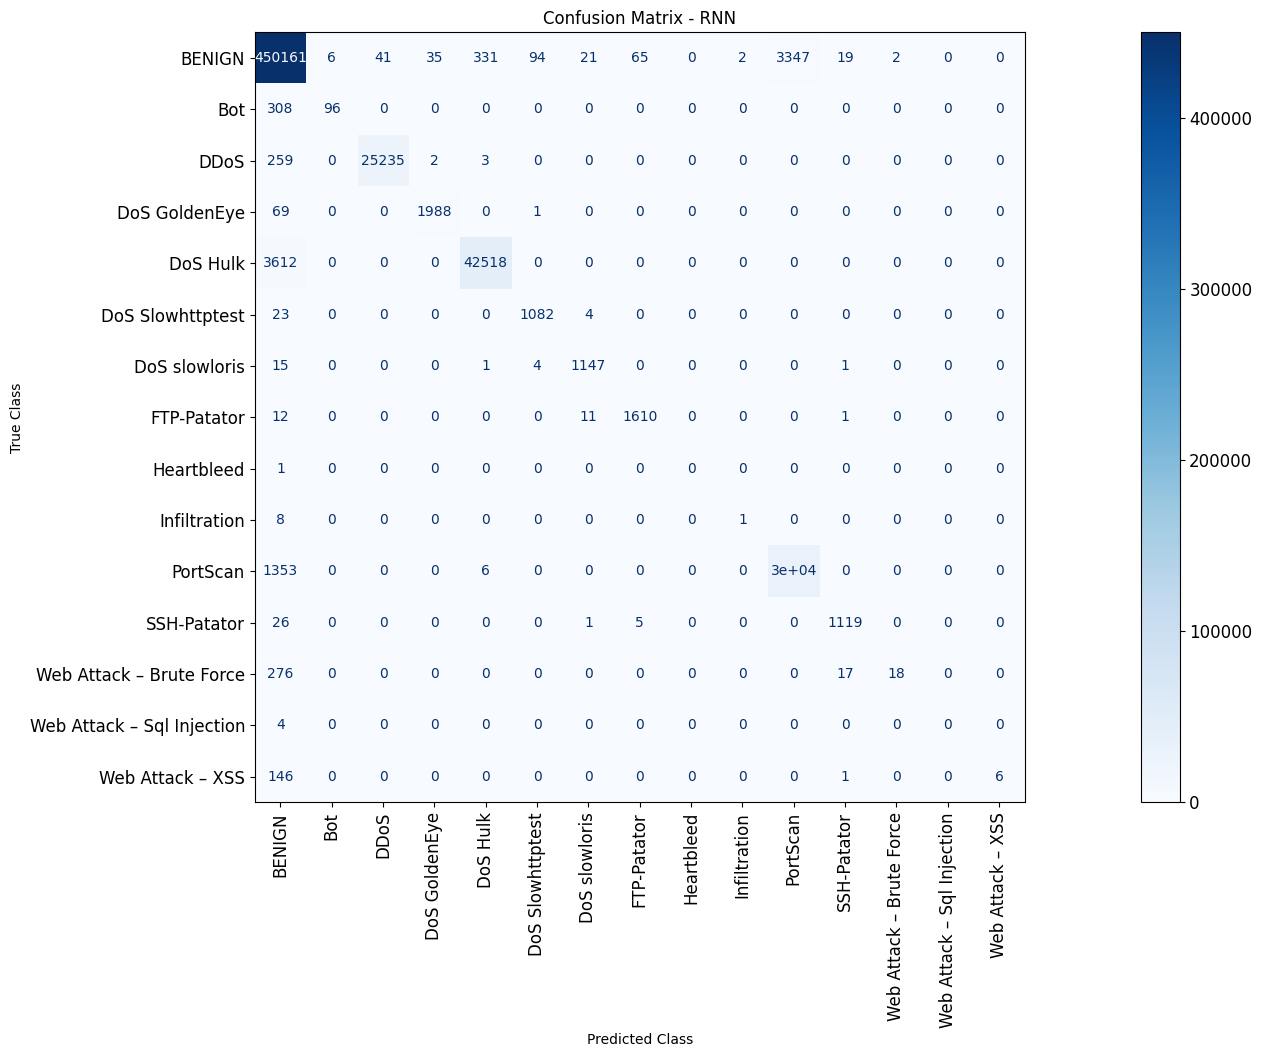

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_true = y_test_onehot.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

matrix = confusion_matrix(y_true, y_pred_classes)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
disp = ConfusionMatrixDisplay(matrix, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.figure_.set_figwidth(30)
disp.figure_.set_figheight(10)

plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()








Accuracy Report for Model Comparison



In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


                            precision    recall  f1-score   support

                    BENIGN       0.99      0.99      0.99    454113
                       Bot       0.92      0.35      0.50       359
                      DDoS       1.00      0.98      0.99     25504
             DoS GoldenEye       0.99      0.96      0.97      2083
                  DoS Hulk       0.99      0.91      0.95     46220
          DoS Slowhttptest       0.91      0.98      0.94      1108
             DoS slowloris       0.98      0.96      0.97      1168
               FTP-Patator       0.96      0.98      0.97      1630
                Heartbleed       1.00      0.50      0.67         2
              Infiltration       0.00      0.00      0.00        10
                  PortScan       0.91      0.96      0.93     31743
               SSH-Patator       0.96      0.97      0.97      1160
  Web Attack – Brute Force       1.00      0.04      0.08       328
Web Attack – Sql Injection       0.00      0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
